
### Problem 1 (2 points)
Under assumptions of Amdahl's law, suppose that 60% of a program are perfectly parallelizable, and the rest is not parallelizable. 
1. What is the maximum speedup achievable by parallelization? 
2. Suppose that we have obtained speedup 2 (by using a suitable number of processes). What is the efficiency of this parallelization? 



### Solution
$\large{1.}$<br>
$$\text{Speedup} = \frac{t_1}{t_n} = \cfrac{t_1}{(1-f)t_1+\frac{f\cdot t_1}{n}} = \cfrac{1}{1-f+\frac{f}{n}}$$
$$\text{let}\quad f = 0.6,\quad 1-f = 0.4\rightarrow \text{Speedup}_{max} = \frac{1}{1-0.6+\frac{0.6}{n}} = 2.5,\quad \text{assuming number of process large enough for}\quad\frac{0.6}{n}\to 0\quad \text{in order to find maximum achievable speedup in our case} $$
$$\quad\text{(so there exists such }n_0: n>n_0\rightarrow\frac{0.6}{n}<\epsilon \quad for\quad \forall \epsilon>0).$$<br>
$\large{2.}$<br>
$$\text{Efficiency} = \frac{\text{Speedup}}{n} \rightarrow 2= \frac{1}{1-0.6+\frac{0.6}{n}},$$
$$0.4+\frac{0.6}{n}=0.5 \rightarrow n = \frac{0.6}{0.1} = 6 \text{ - Suitable number of processes}$$
$$\text{Efficiency} = \frac{\text{Speedup}}{6} = \frac{1}{3}$$

### Problem 2 (2 points)
Write a Python or C/C++ program that uses **MPI reduce** to find the largest file in terms of the  number of lines among all .txt files in the working directory. The program must be callable in the form `mpirun -np <N> python linecount.py` (in the case of the Python version) or `mpirun -np <N> linecount.exe` (the C/C++ version), where `<N>` is the user-defined number of processes. The program is expected to first somehow distribute the files found in the current directory to the processes, then each process should count the lines in the files assigned to it, and finally the result should be MPI-reduced and printed out. 


In [ ]:
# Sample files with different number of strings were generated this way:
for i in range(10):
    fname = 'tmp' + str(i+1) + '.txt'
    file_obj = open(fname, 'w')
    for k in range(i+1):
     file_obj.write(str(i+1)+'\n')
    file_obj.close()

In [ ]:
from mpi4py import MPI
import os
import fnmatch
import math

comm = MPI.COMM_WORLD
R = comm.Get_rank()
S = comm.Get_size()

# Countning the number of files ("." - directory)
A = fnmatch.filter(os.listdir("."), '*.txt')
N = len(A)

# Master-function for finding the file with maximum number of strings
def Fun(List):
    List_of_lengths = []
    # In this list we keep string length of txt files from our directory
    for fname in A:
        file = open(fname, 'r')
        List_of_lengths.append(len(file.readlines()))
        file.close()
    return A[List_of_lengths.index(max(List_of_lengths))]

M = math.floor((len(A)/S))
# Rounding down len(A)/S (if len(A) mod S <> 0 then our 
# last process will work with less than len(A) div S files)
if R == (S - 1):
    filename = Fun(A[R * M:len(A) - 1])
else:
    filename = Fun(A[R * M:(R + 1) * M])
Max = comm.gather(filename, root=0)
if R == 0:
    print('File with maximum number of strings:', Fun(Max))

### Problem 3 (2 points)
Solve the Distinct Substrings problem at Sphere online judge: http://www.spoj.com/problems/DISUBSTR/. Provide code passing the test of the judge. Explain how your code works and theoretically estimate the complexity of the algorithm (as $O(f(N))$, where $f(N)$ is some function of the length of the input string). 


### Solution
The idea of solution is to combine construction of the sorted Suffix Array of given string, and further analyze all prefixes of each suffix of initial string. So we process our string on both sides, first counting all substrings and eliminating repetative ones.
Prefix analysis is basically constructing longest common prefix array, which together with SA construction was discussed in details on seminar. <br>
To count all substrings we should sum $1+2+...+N$, where N is number of letters in the string:  $\sum\limits_{i=1}^ni = \frac{n(n+1)}{2}$ <br>
Number of non-unique strings given by sum of elements of LCP-array: $\sum\limits_{i=1}^nLCP(i)$ $$$$
Number of unique substrings = $\quad\cfrac{n(n+1)}{2}-\sum\limits_{i=1}^nLCP(i)$

We can clearly see the result on Judge test string 'ababa':<br>
Sorted suffix array: [4, 2, 0, 3, 1] (from ['a', 'aba', 'ababa', 'ba', 'baba']), corresponding LCP-array: [0, 1, 3, 0, 2]<br>


All substrings: $\textbf{a, ab, aba, abab, ababa, b, ba, bab, baba, a, ab, aba, b, ba, a}$ (in total 15)


LCP array elements elimination process: <br>
[0, ('a')$\rightarrow$ $\text{nothing}$  <br>
 1, ('aba')$\rightarrow$ $\textbf{a}$  <br>
 3, ('ababa')$\rightarrow$ $\textbf{a, ab, aba}$  <br>
 0, ('ba')$\rightarrow$ $\text{nothing}$  <br>
 2] ('baba')$\rightarrow$ $\textbf{b, ba}$ $$$$
So we have $15-6=9$ distinct substrings.

### Complexity
In this algorithm we have 3 essential parts: sorted Suffix Array construction, LCP Array construction, Body - cycle for input number of strings: <br>
getSA complexity: total complexity is $O(N\log^2 N)$ (since we had one whole seminar dedicated to Suffix Arrays, I suppose there is no need to explain exact parts of code)<br>
getLCP complexity: construction of the whole LCP requires $O(N\log N)$ operations. <br>
Number of strings $<=20$.

Thus, total complexity of whole algorithm is $O(N\log^2 N)$ .

In [1]:
import sys
import numpy as np

def invPerm(p):
    'Invert the permutation p'
    s = np.empty(p.size, p.dtype)
    s[p] = np.arange(p.size)
    return s

def getSA(A):
    if not type(A) is np.ndarray:
        A = np.array(list(A))
    N = len(A) 
    M = int(np.ceil(np.log2(N)))+1   
    # number of iterations (idea - at step 'i' sort length-(2 to the power of 'i') substrings)
    P = np.zeros((M,N), dtype=int) 
    Q = np.zeros((M,N), dtype=int)     
    R = np.zeros((M,3*N), dtype=int) 

    for k in range(M):
        if k == 0:
            P[0] = np.argsort(A)
            Q[0][1:] = np.cumsum(A[P[0]][1:] != A[P[0]][:-1])
            R[0][:N] = Q[0][invPerm(P[0])]
        else:
            offset = 2**(k-1)
            r = np.lexsort((R[k-1, P[k-1]+offset], R[k-1, P[k-1]]))
            P[k] = P[k-1][r]  
            Q[k][1:] = np.cumsum(np.logical_or(R[k-1][P[k]][1:] != R[k-1][P[k]][:-1], 
                                          R[k-1][P[k]+offset][1:] != R[k-1][P[k]+offset][:-1]))
            R[k][:N] = Q[k][invPerm(P[k])]

            if Q[k][-1] == N-1: 
                break

    SA = P[k]
    return SA, P[:k+1], Q[:k+1], R[:k+1]  
   
def getLCP(SA, R):
    (M, N) = R.shape
    LCP = np.zeros((len(SA)-1,),dtype=int)
    for m in range(M-1)[::-1]:
        t = (R[m][SA[1:]+LCP] == R[m][SA[:-1]+LCP]).astype(int)
        LCP += (2**m)*t
    return LCP   
    
num = int(input())
i = 0
# Essential part of task - combining LCP and SA approaches to count distinct substrings
for i in range(num):
 A = input() + '$'
 SA, _, _, R = getSA(A)
 LCP = getLCP(SA, R)
# Since we added extra $ to our string (to mark the end of input string),
# we should modify our formula for counting non-distinct substrings
 l = int((len(A)-1)*(len(A))/2)-LCP.sum()
 print (l)

1
ababa
9




### Problem 4 (2 points)
Suppose that we want to distribute $N$ personal projects to $N$ students. Assume that each student $(k)_{k=0}^{N-1}$ has a list of his/her preferences for the projects, expressed as a vector $\mathbf r_k$ of integer ranks assigned to each project. Ranks vary between 0 and $N-1$ without repetitions, the **lower** the rank the **more preferable** the project. (For example, the first student's ranks are $\mathbf r_0 = [2,1,0]$, the second's $\mathbf r_1 = [0,2,1]$ and the third $\mathbf r_2 = [0,1,2]$). We want to distribute the projects so as to maximize the total preference, i.e., if $n_k$ denotes the project assigned to the $k$'th student, we want to make $f = \sum_{k=0}^{N-1} \mathbf r_k[n_k]$ as small as possible. (In the example above the optimal distribution is $n_0=2, n_1=0, n_2=1$, which gives $f=1$).  
  * Come up with an algorithm optimizing the distribution and implement it in a Python or C/C++ program. The algorithm should accept the preference vectors and output a recommended distribution $(n_k)_{k=1}^N$. The algorithm need not find the best solution, but is expected to generally produce better solutions than would have been obtained by randomly distributing the projects. The algorithm should be reasonably fast, say run in not more than a few seconds for $N=30$. 
  * Compare experimentally your algorithm with the trivial algorithm producing a random distribution. To this end, perform $M=1000$ experiments in each of which 1) random preference vectors for $N=30$ students and projects are generated; 2) the objective function $f$ is evaluated for both algorithms. After finishing all the experiments, plot the two respective distributions of the obtained $M$ values of $f$ and compute the mean values of $f$ for both algorithms. 

### Solution
Algorithm explanation:<br>
Lets imagine 2-dimensional quadratic matrix "projects"-"students" ([1..N] $\cdot$ [1..N]) <br>
\begin{array}{|c|c|}
\hline  & Project 1 & Project 2 & ... \\\hline
  Student 1  & 1 & 2 & ... \\\hline
  Student 2  & 0 & 4 & ... \\\hline
  Student 3  & 3 & 3 & ... \\\hline
  Student 4  & 4 & 1 & ... \\\hline
  Student 5  & 29 & 11 & ... \\\hline
  ...  & ... & ... & ... \\\hline
\end{array} <br>
As we can see from the task decription, values in our columns will not repeat (in row will, but it is totally fine). Intuitive algorithm based on this property - uniqueness of the row values.  We start from first column and try to find project preference = 0 (I understand preference as anti-priority: higher it is, less happier our student. So we also want to show, that smart algorithm will have less sum of preferences of all students). In the second column we seek for preference 0 or 1. So on the $k$-th project we will seek for preference $<= k-1$ (of course, with least value of preference). 

In [30]:
import matplotlib as plt
import numpy as np
import seaborn as sns
from random import shuffle

# Number of students\projects
N = 30
test = []
alg = []
# Function that represents the main idea 
def Project_finder(st, pr, n):
    a=0
    for i in range(n+1): # cycle for students
        l = False
        for j in pr: # moving through projects
            if st.index(i) == j: # found matching priority
                l = True # raising flag if targer index is found then interrupting our cycle
                break 
        if not l: 
            a = i
            pr.append(st.index(i))   
    return a

# Intermediate calculations (for big test)
def calc():
    studs = []
    dist = []
    p = []
    j = 0
    f = 0
    t = 0
    # Randomizer from google for test algorithm
    for i in range(0,N):
        b = sorted(a, key = lambda *args: random.random())
        studs.append(b)
        
    # Algorithm student distributor
    for s in studs:
        dist.append(Project_finder(s,p,j))
        j = j + 1
    # Randomized input data (also randomizer inspired by simplest googlable solution)
    rand=sorted(a, key = lambda *args: random.random())
    for i in range(0,len(studs)):f = studs[i][rand[i]] + f
        
    return [sum(dist), f]

# Body
for i in range(0, 1000):
    alg_res, rand_res = calc()
    alg.append(alg_res)
    test.append(rand_res)   


So our algorithms shows much less sum of preferences and also distribution of values of possible sums is much more narrow (so it is better overall). I guess Hungarian-like Algorithms work better, but we were not supposed to find the best solution.

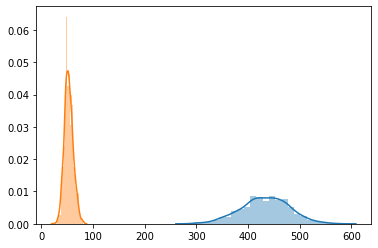

In [31]:
# Visualization    
sns.distplot(test)
sns.distplot(alg)

  
### Problem 5 (2 points)
Suppose that we have developed an algorithm that is supposed to generate independent (quasi-)random numbers uniformly distributed in the interval $[0,1]$. To test our algorithm, we perform a series of experiments. In each experiment, we generate $N=10^3$ numbers $(x_n)_{n=1}^N$ with our algorithm, and compute the minimum distance $r=\min_{1 \le n < m\le N}|x_n-x_m|$ between them. We observe that in more than 99% of such experiments we obtain $r<10^{-5}$. Does this observation contradict the hypothesis of generating independent uniformly distributed random numbers? Explain your answer.

### Solution
To satisfy the $r<10^{-5}$ criteria let's estimate upper and lower bound of the probability $P(distance > 10^{-5})$<bf> 
At first we want to look at upper bound so let's consider the "worst" case: let's quantify the probability P_1 of this configuration:  $\quad\underbrace{0\xleftarrow{r}\cdot\xrightarrow{r}\cdot...1}_{10^{3} dots}$<br>
Let's consider the distance between our dots minimal possible(r + $\epsilon$ $\Rightarrow$ dots are lying on the edges of intervals $[\xleftarrow{r}\cdot\xrightarrow{r}]$):<br>
$P(distance > 10^{-5})<P_1 \rightarrow 1-P(distance > 10^{-5})=P(distance < 10^{-5})>1-P_1$ (should be > $99$%) <br> <br>
Since we put dots on $[0;1]$ consequently, probability of the $1^{\text{st}}$ dot will be $1-r$, for the second will be $1-(r\cdot 2),... \Rightarrow P_1 = \prod\limits_{n=1}^{999}(1-r\cdot n)$

Another "critical" case (only estimation of $P_1$ will be ok I suppose, but interestingly enough we can evaluate kind of "boundary" of opposite case) - distance between dots is at least $2r$ (so intervals of $[\xleftarrow{r}\cdot\xrightarrow{r}]$ are not crossing):$\quad\underbrace{0\xleftarrow{2r}\cdot\xrightarrow{2r}\cdot...1}_{10^{3} dots}$<br>
Idea is the same: probability of the $1^{\text{st}}$ dot will be $1-2\cdot r$, for the second will be $1-2\cdot(2\cdot ),... \Rightarrow P_2 = \prod\limits_{n=1}^{999}(1-2r\cdot n)$


$$\prod\limits_{n=1}^{999}(1-2r\cdot n)=P_2 < P(distance > 10^{-5}) < P_1=\prod\limits_{n=1}^{999}(1-r\cdot n)$$
$$0.04 \cdot 10^{-3} < P(distance > 10^{-5}) < 6.66 \cdot 10^{-3}$$<br>
As we can see $1-P_1>99$% so everything is totally fine and nothing contradicts our hypothesis.